In [1]:
# Gonna look at spectral frequency decomposition
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.stats import binned_statistic

In [ ]:
wavelengths = np.linspace(580e-9, 590e-9, 1000)

diameter = 0.125
period = 304e-6

min_wavelength = np.min(wavelengths)

max_spec_freq = (np.sqrt(2)/period) * (diameter/min_wavelength)
nyquist_sample_rate = 1/(2*max_spec_freq)

freq_1 = 0.25 * max_spec_freq
freq_2 = 0.75 * max_spec_freq
freq_3 = 1.5 * max_spec_freq

spectrum = np.sin(2 * np.pi * freq_1 * wavelengths) + np.sin(2*np.pi*freq_2*wavelengths) + np.sin(2*np.pi*freq_3*wavelengths) + 3

spectrum_cutoff = np.sin(2 * np.pi * freq_1 * wavelengths) + np.sin(2*np.pi*freq_2*wavelengths) + 3

sample_rate = 0.25*nyquist_sample_rate #quarter nyquist

n_wavelengths_sample = int(np.floor((10e-9)/sample_rate))
print(n_wavelengths_sample)

wavelengths_sample = np.linspace(580e-9, 580e-9 + sample_rate*n_wavelengths_sample, n_wavelengths_sample)
print(wavelengths_sample[-1])

weights_initial = np.ones(n_wavelengths_sample)

flux = 1000000
difference = np.pi * 0.348
flux_renorm = flux/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=spectrum)

source_model = dl.PointSource(wavelengths_sample, flux=flux_renorm, weights=weights_initial)

wf_npixels = 128 # 128 lowest power of 2 necessary

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 64
psf_pixel_scale = 0.375
oversample = 4 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

center_wl = 585e-9

telescope = dl.Telescope(optics, source)
telescope_model = dl.Telescope(optics, source_model)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_model = dlT.SideLobeTelescope(telescope_model, period, difference)

sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, downsample = oversample)

sidelobe_poisson = jr.poisson(jr.PRNGKey(0), sidelobe_raw)

80
5.8997415e-07
Model time: 15.5253 seconds.


In [34]:
weights_path = 'telescope.source.spectrum.weights'

parameters = [weights_path]

# initial guess for weights, uniform ones!
#model = sidelobescope.set(weights_path, np.ones(n_lambda)/n_lambda)
# new oversampled model
model = models_out[-1]

# Optimisation
# 10% initial learning rate.
weights_optimiser = optax.adam(0.01)

optimisers = [weights_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [35]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model_sidelobes(center_wavelength = center_wl, downsample = oversample)
    return np.sum((data-out)**2)
    #return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [36]:
losses, models_out = [], []
n_iter = 2000
with tqdm(range(n_iter),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobe_raw)

        updates, opt_state = optim.update(grads, opt_state)

        # # prevent negative weights
        # # Get current weights
        weights = model.get(weights_path)

        # # Get update for weights
        weight_updates = updates.get(weights_path)

        # define epsilon
        epsilon = 1e-6
        safe_updates = np.where(weights + weight_updates < epsilon, epsilon-weights, weight_updates)

        # Create a copy of updates and replace the weights update with safe update
        updates = updates.set(weights_path, safe_updates)

        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/2000 [00:00<?, ?it/s]

Model time: 1.4006 seconds.


Log Loss: 1.872: 100%|██████████| 2000/2000 [03:22<00:00,  9.88it/s]


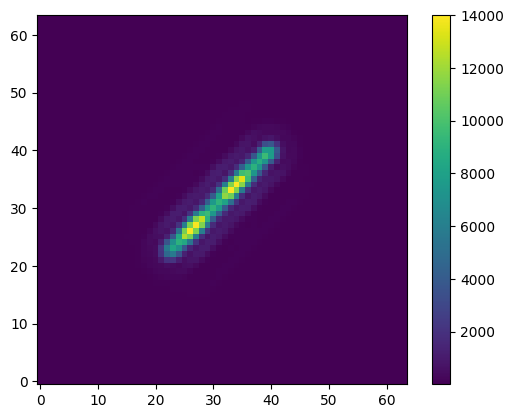

973537.2


In [27]:
plt.imshow(sidelobe_raw, origin='lower')
plt.colorbar()
plt.show()
print(np.sum(sidelobe_raw))

In [33]:
new_weights = models_out[-1].weights

In [42]:
losses_array = np.array(losses)

print(np.argmin(losses_array))
least_loss_model = models_out[1767]

least_loss_sidelobe = least_loss_model.model_sidelobes(center_wavelength=center_wl, downsample=oversample)

1767
Model time: 1.3101 seconds.


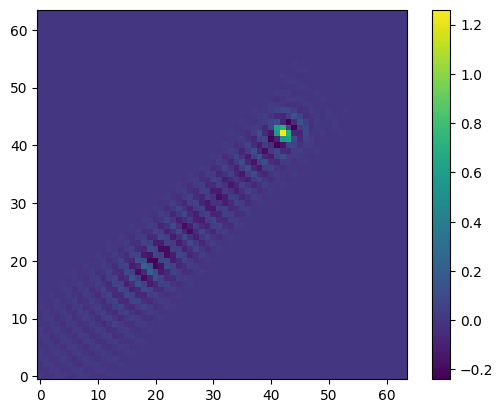

In [44]:
least_loss_weights = least_loss_model.weights

plt.imshow(least_loss_sidelobe-sidelobe_raw, origin='lower')
plt.colorbar()
plt.show()

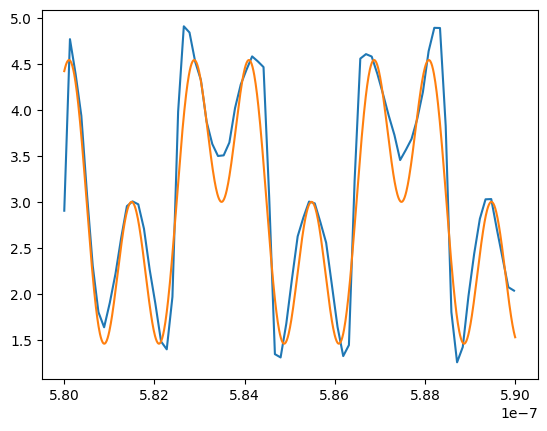

In [51]:
plt.plot(wavelengths_sample, 7*least_loss_weights)
plt.plot(wavelengths, spectrum_cutoff)
plt.show()

In [70]:
weights_ft = np.fft.fft(least_loss_weights)
freqs = np.fft.fftfreq(n_wavelengths_sample, d=sample_rate)
# just realised sample rate is actually sample interval, not a rate

weights_ft_filtered = weights_ft.at[np.abs(freqs) > max_spec_freq].set(0)

weights_filtered = np.fft.ifft(weights_ft_filtered).real # do I take real or absolute? idk shouldnt make much of a difference
# should be real though I checked

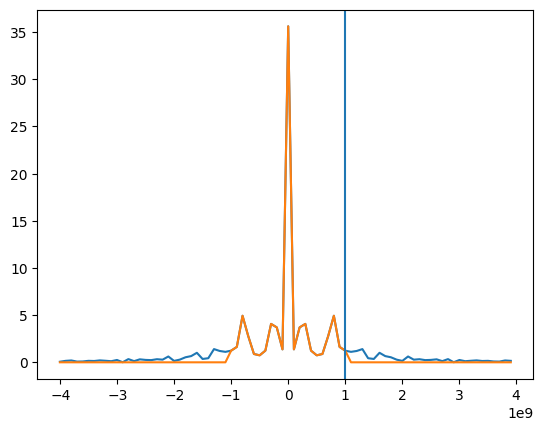

In [72]:
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(weights_ft)))
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(weights_ft_filtered)))
plt.axvline(max_spec_freq)
plt.show()


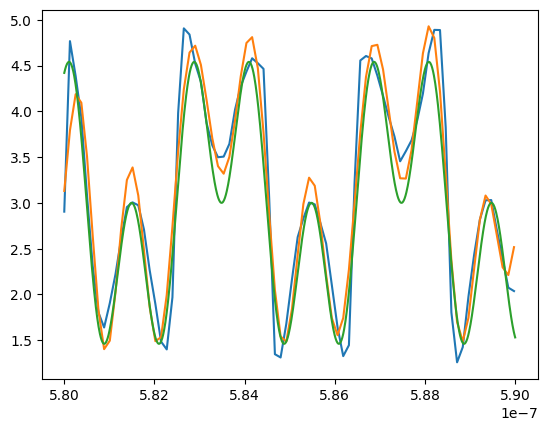

In [82]:
plt.plot(wavelengths_sample, 7*least_loss_weights)
plt.plot(wavelengths_sample, 7*weights_filtered)
plt.plot(wavelengths, spectrum_cutoff)
plt.show()

In [77]:
def sinc_interp(xi, x, y):
    # xi: new points, x: original, y: filtered signal
    sinc_matrix = np.sinc((xi[:, None] - x[None, :]) / sample_rate)
    return sinc_matrix @ y  # shape: (len(xi),)

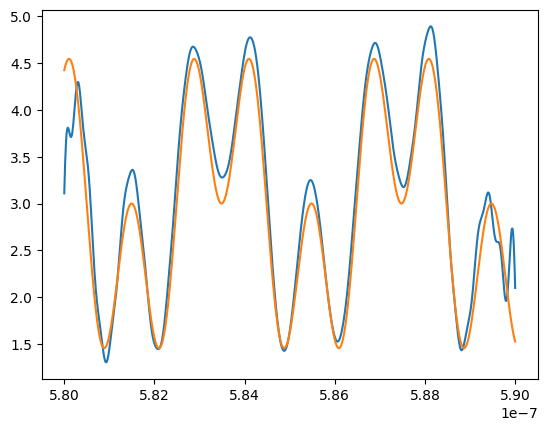

In [95]:
weights_reconstructed = sinc_interp(wavelengths, wavelengths_sample, weights_filtered)
weights_reconstructed_uf = sinc_interp(wavelengths, wavelengths_sample, least_loss_weights)
plt.plot(wavelengths, 7*weights_reconstructed)
plt.plot(wavelengths, spectrum_cutoff)
#plt.plot(wavelengths, 7*weights_reconstructed_uf)
plt.show()

In [104]:
weights_r_ft = np.fft.fft(weights_reconstructed)
freqs_r = np.fft.fftfreq(1000, d=(10e-9)/1000)
# just realised sample rate is actually sample interval, not a rate

weights_r_ft_filtered = weights_r_ft.at[np.abs(freqs_r) > 0.9*max_spec_freq].set(0)

weights_r_filtered = np.fft.ifft(weights_r_ft_filtered).real # do I take real or absolute? idk shouldnt make much of a difference
#should be real though I checked

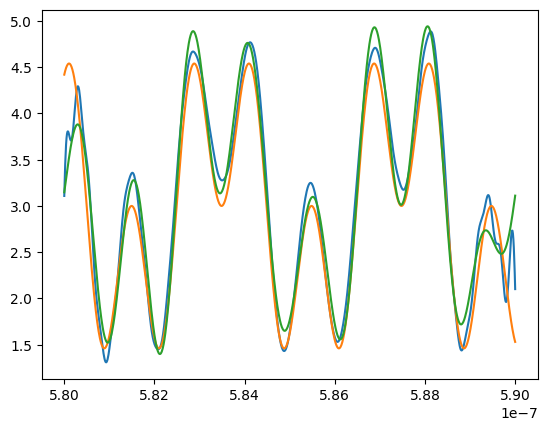

In [105]:
plt.plot(wavelengths, 7*weights_reconstructed)
plt.plot(wavelengths, spectrum_cutoff)
plt.plot(wavelengths, 7*weights_r_filtered)
plt.show()

In [92]:
print(weights_r_ft)

[ 4.40270325e+02+0.00000000e+00j -1.48962927e+01+6.79429531e+00j
 -3.63429108e+01+2.98789959e+01j  3.48580017e+01-3.43311462e+01j
  1.22816544e+01-1.02193623e+01j  9.54607582e+00-3.36312246e+00j
  1.16964722e+01+3.55509877e+00j  2.97026024e+01+2.76852226e+01j
 -3.18953018e+01-4.56253891e+01j -1.02728167e+01-1.86955242e+01j
 -9.39009571e+00-1.50007935e+01j -7.64177084e-01-2.72470069e+00j
 -2.08289027e-01-1.79976177e+00j  4.49549332e-02-1.36164773e+00j
  1.64063245e-01-1.12503910e+00j  2.48915091e-01-9.40722883e-01j
  3.13166797e-01-8.13900769e-01j  3.40190709e-01-6.99164569e-01j
  3.67854923e-01-6.27037644e-01j  3.91927719e-01-5.67340136e-01j
  4.31277871e-01-4.95681971e-01j  4.06623304e-01-4.60641742e-01j
  4.52894270e-01-4.09244657e-01j  4.59067255e-01-3.65203619e-01j
  4.45081532e-01-3.20011109e-01j  4.76844281e-01-3.11274678e-01j
  4.79118049e-01-2.71527231e-01j  4.86221820e-01-2.28648096e-01j
  4.74109828e-01-2.07757086e-01j  5.05917072e-01-1.80812195e-01j
  4.83237565e-01-1.397572

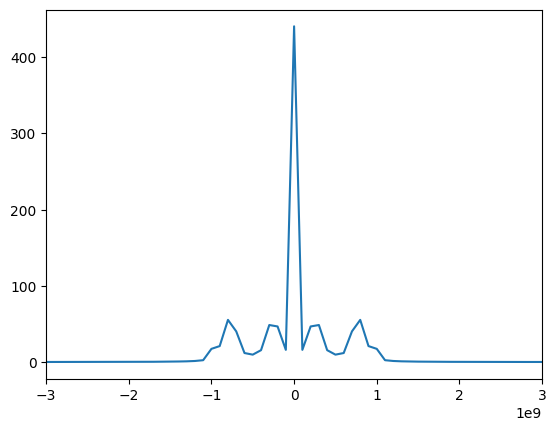

In [93]:
plt.plot(np.fft.fftshift(freqs_r), np.fft.fftshift(np.abs(weights_r_ft)))
plt.xlim(-3e9, 3e9)
plt.show()

In [ ]:
plt.plot(wavelengths, spectrum)
plt.plot(wavelengths, spectrum_cutoff)
plt.show()